In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
import cv2

2023-05-15 22:22:44.241154: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-15 22:22:44.276731: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 22:22:44.417974: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-15 22:22:44.418937: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-15 22:22:45.196657: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
#Add the folder where the functions for gradient descent are implemented
import sys
sys.path.insert(1, '../src')
from functions import *

Load the training set and split it in training and validation to train the model. I will use the function "image_dataset_from_directory" in keras.utils

In [5]:
training = tf.keras.utils.image_dataset_from_directory(directory=TRAIN_PATH,
                                                       subset = "training",
                                                       class_names=os.listdir(TRAIN_PATH),
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=0.2,
                                                       image_size=(HEIGHT,WIDTH),
                                                       seed=42) #important to have the same seed

validation = tf.keras.utils.image_dataset_from_directory(directory=TRAIN_PATH,
                                                       subset = "validation",
                                                       class_names=os.listdir(TRAIN_PATH), 
                                                       batch_size=BATCH_SIZE,
                                                       validation_split=0.2,
                                                       image_size=(HEIGHT,WIDTH),
                                                       seed=42) #important to have the same seed

#test = tf.keras.utils.image_dataset_from_directory(directory=TEST_PATH,
#                                                       CLASS_NAMES=os.listdir(TRAIN_PATH), 
#                                                       batch_size=1700,
#                                                       image_size=(HEIGHT,WIDTH),
#                                                       shuffle=False)

Found 25618 files belonging to 12 classes.
Using 20495 files for training.
Found 25618 files belonging to 12 classes.
Using 5123 files for validation.


Check if the function loaded correctly the classes

In [ ]:
class_names = training.class_names
print(class_names)

['lasagna', 'burrito', 'tacos', 'sushi', 'gyoza', 'pizza', 'sashimi', 'edamame', 'pasta', 'risotto', 'nachos', 'ramen']


Plot some of the pictures from the training set with their label, to check if they are set correctly

2023-05-13 08:57:02.279878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [20495]
	 [[{{node Placeholder/_4}}]]
2023-05-13 08:57:02.280129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [20495]
	 [[{{node Placeholder/_0}}]]


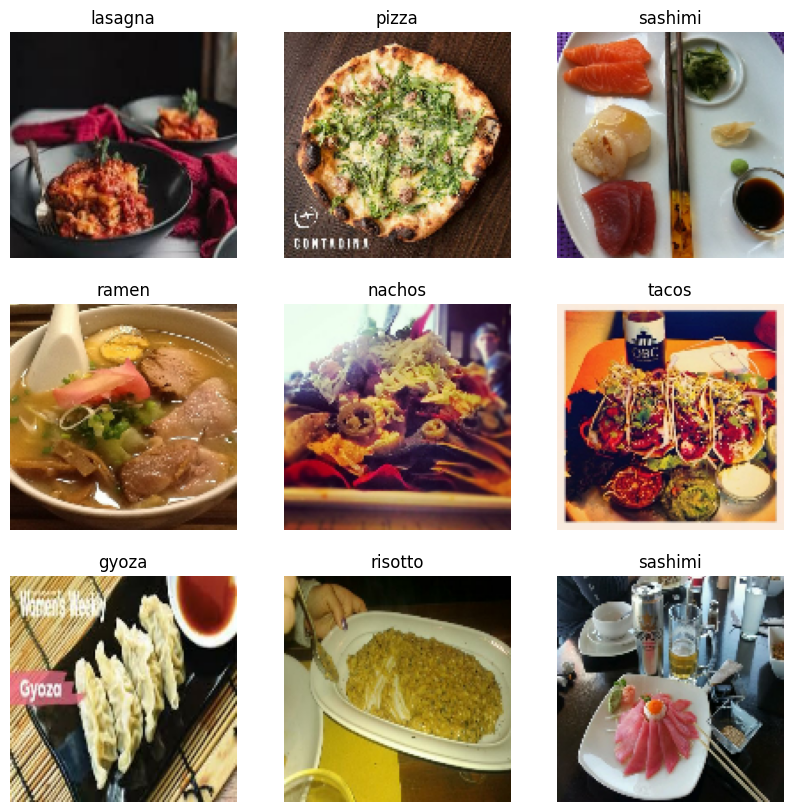

In [4]:
plt.figure(figsize=(10, 10))
for images, labels in training.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


In [5]:
for image_batch, labels_batch in training:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

2023-05-11 09:15:26.268917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [21148]
	 [[{{node Placeholder/_4}}]]
2023-05-11 09:15:26.269189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [21148]
	 [[{{node Placeholder/_0}}]]


(128, 128, 128, 3)
(128,)


Applying data_augmentation to the training set

In [5]:
data_augmentation = tf.keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical"),
  keras.layers.RandomRotation(0.1), # Fraction of 2Pi
  keras.layers.RandomZoom(height_factor=0.3, width_factor=0.3),
  keras.layers.RandomBrightness(factor=0.2),
  keras.layers.RandomContrast(factor=0.2)
])


In [6]:
new_train = training.map(lambda x, y: (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE)
new_train = new_train.prefetch(buffer_size=tf.data.AUTOTUNE)


First model I tried

In [15]:
n_classes = 4

model = keras.models.Sequential()

model.add(keras.layers.Rescaling(1./255))
model.add(keras.layers.Conv2D(filters=16, kernel_size=3, padding="same", activation="relu", input_shape=(HEIGHT,WIDTH, 3)))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.35))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.35))
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.35))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.35))
model.add(keras.layers.Dense(n_classes, activation="softmax"))

Model from [https://arxiv.org/pdf/1612.00983.pdf](https://arxiv.org/pdf/1612.00983.pdf)

In [110]:
n_classes = 7

model = keras.models.Sequential()

model.add(keras.layers.Rescaling(1./255))
model.add(keras.layers.Conv2D(filters=32, kernel_size=5, padding="same", activation="relu", input_shape=(HEIGHT,WIDTH, 3)))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(filters=64, kernel_size=5, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding="same", activation="relu"))
model.add(keras.layers.MaxPool2D())
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation="relu"))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(n_classes, activation="softmax"))

Deeper model. This is the final model I tried. The structure of the best model is similar to this one but with more filters (more parameters) and a few differences. We will see it in the section where I load the best model from the saved h5 file.

In [17]:
n_classes = 12
input = keras.layers.Input(shape=(HEIGHT, WIDTH, 3), name="img")

x = keras.layers.Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.L2(l2=5e-4), padding="same", activation="relu")(input)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Conv2D(32, kernel_size=3, kernel_regularizer=keras.regularizers.L2(l2=5e-4), padding="same", activation="relu")(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Conv2D(64, kernel_size=3, kernel_regularizer=keras.regularizers.L2(l2=5e-4), padding="same", activation="relu")(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Conv2D(128, kernel_size=3, kernel_regularizer=keras.regularizers.L2(l2=5e-4), padding="same", activation="relu")(x)
x = keras.layers.MaxPool2D()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dropout(0.35)(x)
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(units=128, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=64, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=32, activation="relu")(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(units=n_classes, activation="softmax")(x)
model = tf.keras.models.Model(input, x)

In [18]:
model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_20 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_31 (Dropout)        (None, 64, 64, 32)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 32, 32, 32)       0         
 g2D)                                                      

In [19]:
model.compile(optimizer="adam", 
              loss = "sparse_categorical_crossentropy",
              metrics = ["accuracy"]
              )

Here I am showing the results of the training of the last model I tried, this is not the best one, which results I will show later in the next section of the notebook where I load the best model.

In [45]:
checkpoint = keras.callbacks.ModelCheckpoint("checkpoint_new.h5")

history6 = model.fit(new_train,
                    epochs=300, 
                    #batch_size=128, 
                   validation_data=validation,
                   callbacks=[checkpoint])

df_hist6 = pd.DataFrame(history6.history)
df_hist6.to_csv("history_32f3s_32f3ksame_64f3k_128f3k_d128n_d64_d32_12FoodClasses_BatchNorm_L2_lessRisotto_p6.csv")

Epoch 1/300
161/161 [==============================] - 84s 518ms/step - loss: 1.7390 - accuracy: 0.4700 - val_loss: 1.8552 - val_accuracy: 0.4613
Epoch 2/300
161/161 [==============================] - 84s 514ms/step - loss: 1.7508 - accuracy: 0.4677 - val_loss: 2.1545 - val_accuracy: 0.3998
Epoch 3/300
161/161 [==============================] - 82s 501ms/step - loss: 1.7219 - accuracy: 0.4753 - val_loss: 2.3053 - val_accuracy: 0.3799
Epoch 4/300
161/161 [==============================] - 84s 515ms/step - loss: 1.7356 - accuracy: 0.4701 - val_loss: 1.8051 - val_accuracy: 0.4630
Epoch 5/300
161/161 [==============================] - 82s 502ms/step - loss: 1.7281 - accuracy: 0.4728 - val_loss: 1.9069 - val_accuracy: 0.4378
Epoch 6/300
161/161 [==============================] - 84s 514ms/step - loss: 1.7343 - accuracy: 0.4727 - val_loss: 1.8092 - val_accuracy: 0.4501
Epoch 7/300
161/161 [==============================] - 82s 504ms/step - loss: 1.7037 - accuracy: 0.4787 - val_loss: 1.8658 -

In [46]:
df_hist6

loss  accuracy  val_loss  val_accuracy
0    1.739044  0.470017  1.855189      0.461253
1    1.750788  0.467675  2.154462      0.399766
2    1.721863  0.475335  2.305258      0.379856
3    1.735582  0.470115  1.805073      0.463010
4    1.728052  0.472798  1.906944      0.437829
..        ...       ...       ...           ...
295  1.663805  0.511588  1.739644      0.478235
296  1.666803  0.509685  1.623657      0.528597
297  1.655213  0.514028  1.708688      0.516104
298  1.673244  0.508856  2.168271      0.453055
299  1.653259  0.520517  1.556642      0.541089

[300 rows x 4 columns]

In [35]:
model.save("model_32f5s_64f5ksame_64f3k_128f3k_d128n_12FoodClasses.h5")

This part of the code is just to concat history from previous part of the training and generate a final plot

In [48]:
#df_hist6.index = pd.RangeIndex(320,620,1)
#df_hist_tot = pd.concat((df_hist, df_hist2, df_hist3, df_hist4, df_hist5, df_hist6))#, df_hist3, df_hist4))
#df_hist_tot

loss  accuracy  val_loss  val_accuracy
0    2.675535  0.100756  2.555213      0.109116
1    2.556745  0.108270  2.582481      0.094085
2    2.547540  0.111637  2.567977      0.076713
3    2.545397  0.107246  2.587026      0.078079
4    2.539642  0.106416  2.575706      0.079055
..        ...       ...       ...           ...
615  1.663805  0.511588  1.739644      0.478235
616  1.666803  0.509685  1.623657      0.528597
617  1.655213  0.514028  1.708688      0.516104
618  1.673244  0.508856  2.168271      0.453055
619  1.653259  0.520517  1.556642      0.541089

[620 rows x 4 columns]

In [49]:
df_hist_tot.to_csv("history_32f3s_32f3ksame_64f3k_128f3k_d128n_d64_d32_12FoodClasses_BatchNorm_L2_lessRisotto_tot.csv")

## Saved model

In [9]:
model = tf.keras.models.load_model("../model/my_model.h5")

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      4864      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 64, 64, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        102464    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                         

In [11]:
df_hist_tot = pd.read_csv("../history/history_model_64f5s_64f5ksame_128f3k_128f3k_d128n_12FoodClasses_BatchNorm_L2_tot.csv")

I show here the accuracy and loss during training. A bitter note here is that for an unexpected error I was not able to save the last part of the history where I reached the best accuracy on validation (0.65), but what I show here is almost there.

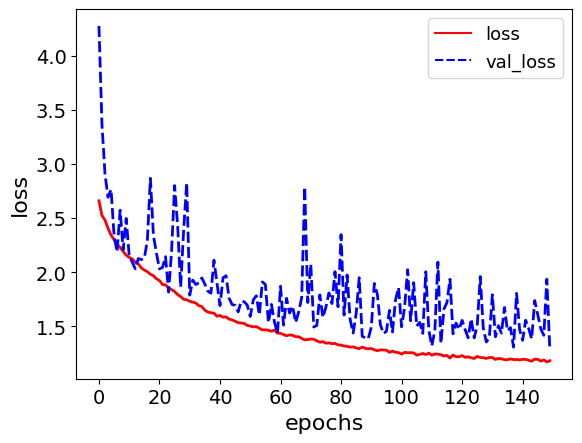

In [12]:
sns.lineplot(df_hist_tot[["loss", "val_loss"]], palette=['r', 'b'], linewidth=2)
plt.xlabel("epochs", fontsize=16)
plt.ylabel("loss", fontsize=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize=13)
#plt.savefig("loss_finalModel.png")
#plt.ylim(1,2.5)

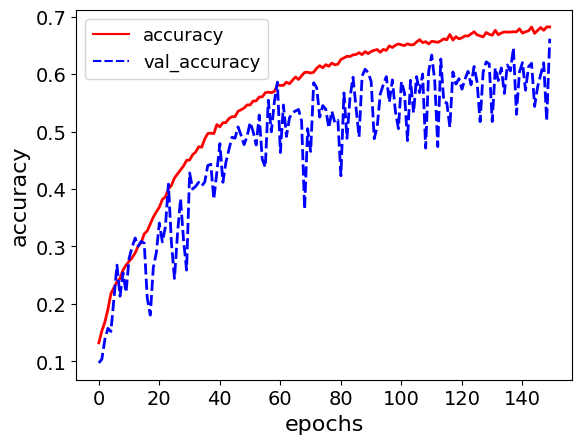

In [13]:
sns.lineplot(df_hist_tot[["accuracy", "val_accuracy"]], palette=['r', 'b'], linewidth=2)
plt.xlabel("epochs", fontsize=16)
plt.ylabel("accuracy", fontsize=16)
plt.xticks(fontsize=14);
plt.yticks(fontsize=14);
plt.legend(fontsize=13)
plt.savefig("accuracy_finalModel.png")
#plt.ylim(1,2.5)

We notice that accuracy and loss of training look like they are both saturating. Validation is very noisy but it doesn't show signs of overfitting yet. This means that we could further train the model and probably gain some more, but I wouldn't expect to gain too much more because training loss is saturating.

The fact that we are not seeing overfitting yet means that we could even try to go deeper with the CNN. Unfortunately due to time and resources limitations (on my laptop without gpu this model with 25k pictures ran for around 200/300s per epoch) I couldn't explore more configurations. I am quite convinced that we could get better results with some different NN architecture. I will discuss this further mode in the next section.

## Predictions

Let's take a look at how the model is predicting on the validation set. I want to check if it is able to properly distinguish the classes, assigning high probabilities to the class that the model predict.

In [14]:
y_preds = model.predict(validation)

2023-05-15 22:25:14.472505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5123]
	 [[{{node Placeholder/_4}}]]
2023-05-15 22:25:14.472978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5123]
	 [[{{node Placeholder/_4}}]]


41/41 [==============================] - 20s 483ms/step


In [15]:
very_low_prob = [y for y in y_preds if max(y)<0.25]
low_prob = [y for y in y_preds if max(y)<0.5 and max(y)>=0.25]
medium_prob = [y for y in y_preds if max(y)<0.8 and max(y) >=0.5]
high_prob = [y for y in y_preds if max(y) >=0.8]

In [16]:
print("percentage with prob lower than 0.25:",round(len(very_low_prob)/len(y_preds),2))
print("percentage with prob between 0.25 and 0.5:",round(len(low_prob)/len(y_preds),2))
print("percentage with prob between 0.5 and 0.8 :",round(len(medium_prob)/len(y_preds),2))
print("percentage with prob higher than 0.8:",round(len(high_prob)/len(y_preds),2))

percentage with prob lower than 0.25: 0.03
percentage with prob between 0.25 and 0.5: 0.23
percentage with prob between 0.5 and 0.8 : 0.32
percentage with prob higher than 0.8: 0.42


We can see that only for 3% of the predictions the model is very unsure on how to classify the image.

#### Accuracy and confusion matrix

In [52]:
y_pred = []  # store predicted labels
y_true = []  # store true labels
# iterate over the dataset
for image_batch, label_batch in validation:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

2023-05-13 10:01:09.589000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5123]
	 [[{{node Placeholder/_4}}]]
2023-05-13 10:01:09.589262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [5123]
	 [[{{node Placeholder/_4}}]]


1/1 [==============================] - 0s 133ms/step


In [53]:
len(y_preds)

5123

In [54]:
correct_labels

<tf.Tensor: shape=(5123,), dtype=int32, numpy=array([11,  5,  1, ...,  4,  1,  0], dtype=int32)>

In [55]:
predicted_labels

<tf.Tensor: shape=(5123,), dtype=int64, numpy=array([11,  5,  1, ..., 11,  0,  9])>

In [75]:
confusion_matrix(correct_labels, predicted_labels)

array([[277,   7,   3,   1,   2,  19,   0,   0,  11,  58,   3,   3],
       [ 66, 172,  43,   3,   8,   5,   1,   0,  10,  73,   7,  11],
       [ 25,  41, 325,   2,   0,  10,   2,   4,  19,  50,  23,  14],
       [ 14,  11,  18, 293,   4,   9,  74,   5,   0,  50,  11,   5],
       [ 48,  21,   4,   5, 201,   5,   1,   1,   6,  51,   5,   9],
       [ 89,   1,   8,   0,   1, 380,   0,   1,   2,  21,   4,   3],
       [  7,   7,   8,  23,   8,   3, 352,   1,   1,  22,   1,  11],
       [  0,   2,   2,   1,   1,   0,   1, 251,   1,   5,   0,   0],
       [ 48,  10,  10,   1,   3,  21,   1,   4, 292, 135,   7,   6],
       [ 20,   3,   1,   2,   1,  11,   2,   0,  11, 386,   2,   7],
       [ 24,   9,  15,   0,   5,  17,   2,   3,  17,  56, 190,   9],
       [ 14,   2,   5,   2,   1,   4,   0,   2,  19,  75,   3, 298]])

Text(70.72222222222221, 0.5, 'Predicted class')

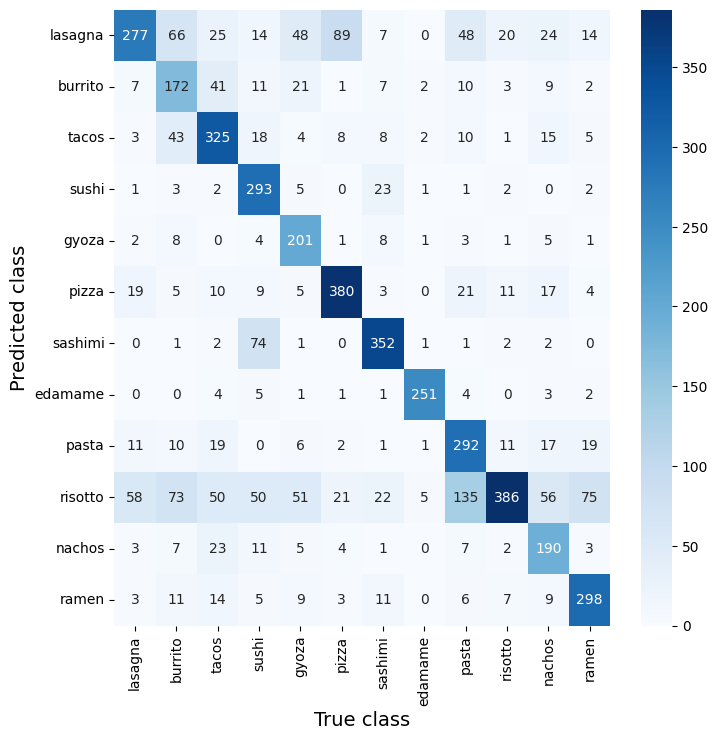

In [76]:
dict_labels = {i : elem for i,elem in enumerate(os.listdir(TRAIN_PATH))}

yticklabels = os.listdir(TRAIN_PATH)

plt.figure(figsize=(8,8))
ax = sns.heatmap(confusion_matrix(correct_labels, predicted_labels).T, annot=True, fmt=".0f", cmap='Blues',
            yticklabels=yticklabels, xticklabels=yticklabels)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)

plt.xlabel("True class", fontsize=14)
plt.ylabel("Predicted class", fontsize=14)

#plt.savefig("heatmap_model1_testSet.png")

The model confuses a lot risotto with pasta, which could be understandable. This from the point of view of my objective is not a big deal (as risotto, pasta an lasagna are all italian recipes). The main problem here is that the network is also overpredicting "risotto" for most of the other classes. With this I mean that the NN is saying "risotto" a lot of time even when it is not the case. Also lasagna seems to have a similar behaviour but not as dramatic as risotto.

What could the problem be?

- Biased training data: The training data may contain biases that are causing the CNN to predict one class more frequently. I think that this could be a problem. I realized that the majority of pictures of risotto showed a white plate. I tried to downsample this class and to add more diverse pictures (with more zoom on the risotto, or with different plate coulors), but this didn't help much. I also did the same operation with pasta and lasagna. It didn't help. 

- Model architecture: The CNN architecture may not be suitable for the given dataset, or it may be overfitting to the over-represented class. **This might probably be the case here.** Probably the NN is learning some features which are not the relevant ones to identify these dishes, and playing with the architecture might give us the gain we are looking fore. I tried to explore a bit this route, but unfortunately for now lack of time and resources don't allow me to explore further.


- There might be other reasons, like class unbalanced (over-rapresented class), label noise (incorrect labels in the oversampled class), but I don't think these apply in my case because the classes are more or less balanced, and I manually checked the pictures many times so the percentage of mislabel should be low.


Other things:


The NN also confuses sashimi with sushi, which also makes sense, but won't be a problem for my objective. Maybe in this case I could work a bit here on the images in the dataset to solve this confusion. 



#### Final accuracy

In [77]:
accuracy_score(correct_labels, predicted_labels)

0.66699199687683

Now I will load the external test set. I will not use "image_dataset_from_directory" for the test set because it makes thing complicated at the time when you want to check specific images. With the following functions I load all the images and I have everything in control. 

#### Note:

**This method consumes more RAM because it load all the images, so run this code only at the moment of checking the test set, not when you are still training to find the best model!**

In [17]:
class_names_label = {class_name:i for i ,class_name in enumerate(CLASS_NAMES)}
class_names_label

{'lasagna': 0,
 'burrito': 1,
 'tacos': 2,
 'sushi': 3,
 'gyoza': 4,
 'pizza': 5,
 'sashimi': 6,
 'edamame': 7,
 'pasta': 8,
 'risotto': 9,
 'nachos': 10,
 'ramen': 11}

In [18]:
X_test, y_test, file_paths = read_data(TEST_PATH, (HEIGHT,WIDTH), class_names_label)

In [ ]:
len(y_test)

1700

In [19]:
predictions = model.predict(tf.convert_to_tensor(X_test, dtype=tf.int32))

54/54 [==============================] - 6s 112ms/step


In [20]:
preds_test = [x.argmax() for x in predictions]

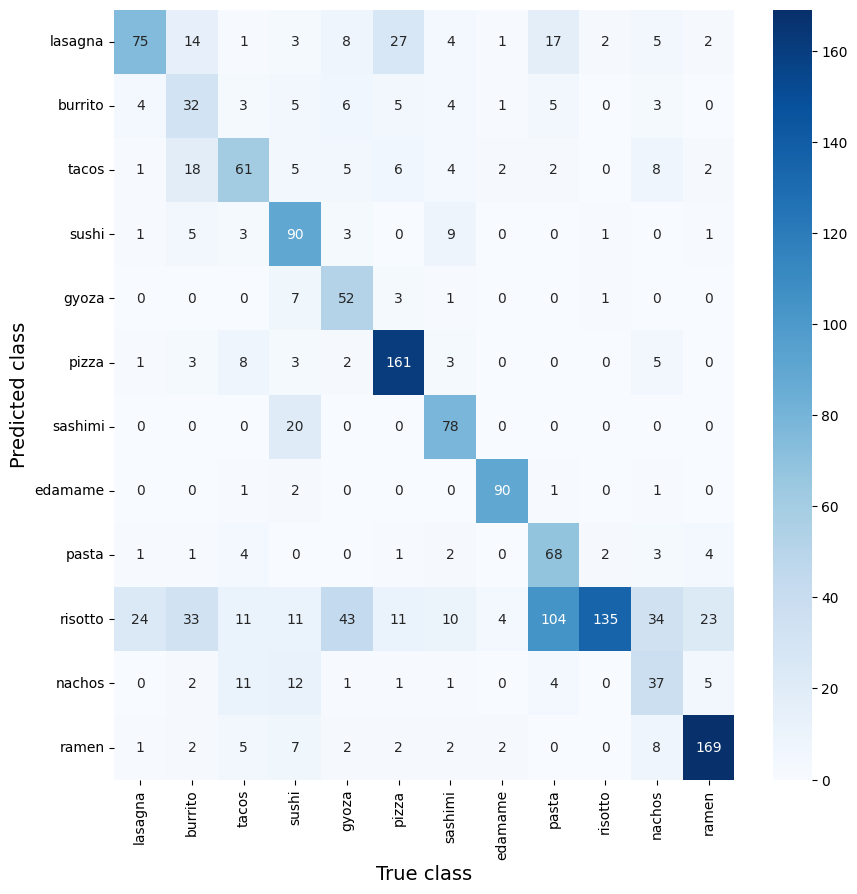

In [21]:
dict_labels = {i : elem for i,elem in enumerate(os.listdir(TEST_PATH))}

yticklabels = os.listdir(TEST_PATH)

plt.figure(figsize=(10,10))
ax = sns.heatmap(confusion_matrix(y_test, preds_test).T, annot=True, fmt=".0f", cmap='Blues',
            yticklabels=yticklabels, xticklabels=yticklabels)
ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)

plt.xlabel("True class", fontsize=14)
plt.ylabel("Predicted class", fontsize=14);

plt.savefig("heatmap_model1_testSet.png")

We see the same type of problems we observed on validation. This is a good sign, because it means our model is at least generalizing well when we use an external test set. Actually the "lasagna" problem seems to be less evident here.

In [22]:
accuracy_score(y_test, preds_test)

0.6164705882352941

A bit lower accuracy, but not dramatic. I think we are doing well generalizing

#### Investigating the uncorrect predictions 

I will now show some samples of images from the ones that the model predict as risotto but they are not risotto

In [81]:
index_wrongPredictedRisotto = [i for i in range(len(preds_test)) if y_test[i]!= preds_test[i] and preds_test[i]==9]

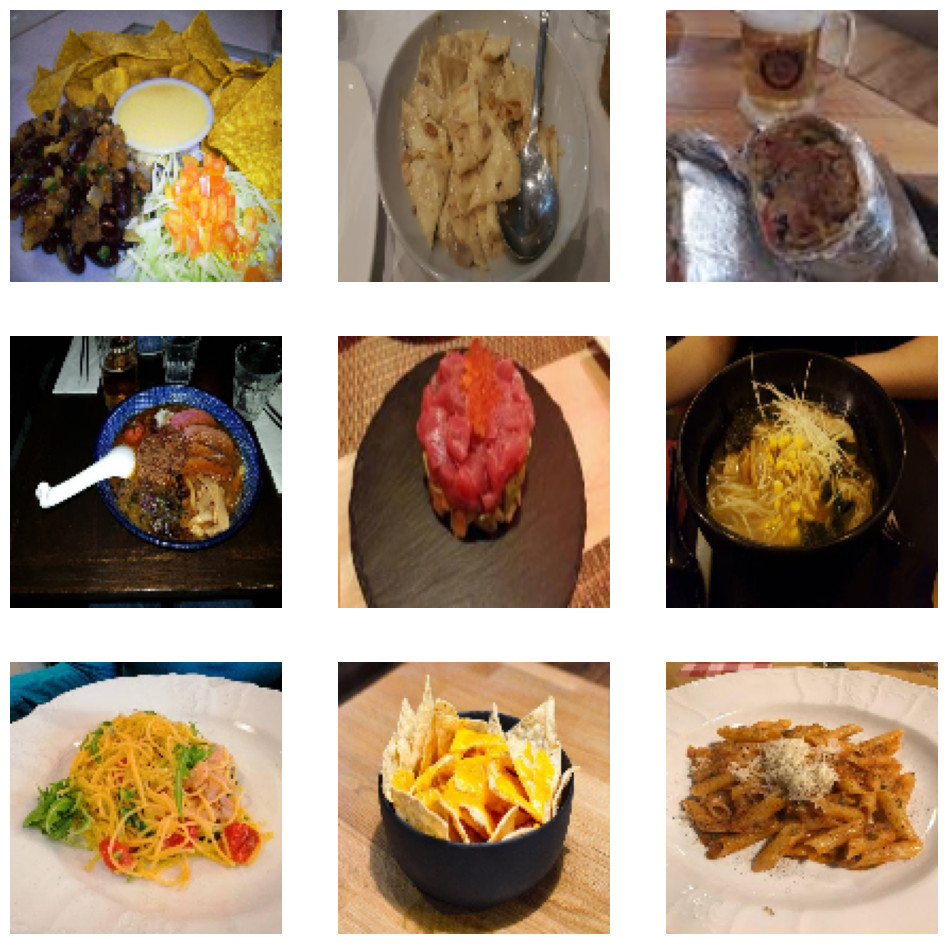

In [98]:

plt.figure(figsize=(12,12))

for i in range(9):
        index = np.random.choice(index_wrongPredictedRisotto)
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(X_test[index])
        plt.axis("off")



Let's put the focus on some specific class

In [139]:
index_PredRisotto_TruePasta = [i for i in range(len(preds_test)) if y_test[i]!= preds_test[i] and preds_test[i]==9 and y_test[i]==8]

In [144]:
index_PredRisotto_TrueGyoza = [i for i in range(len(preds_test)) if y_test[i]!= preds_test[i] and preds_test[i]==9 and y_test[i]==4]

In [140]:
len(index_PredRisotto_TruePasta)

104

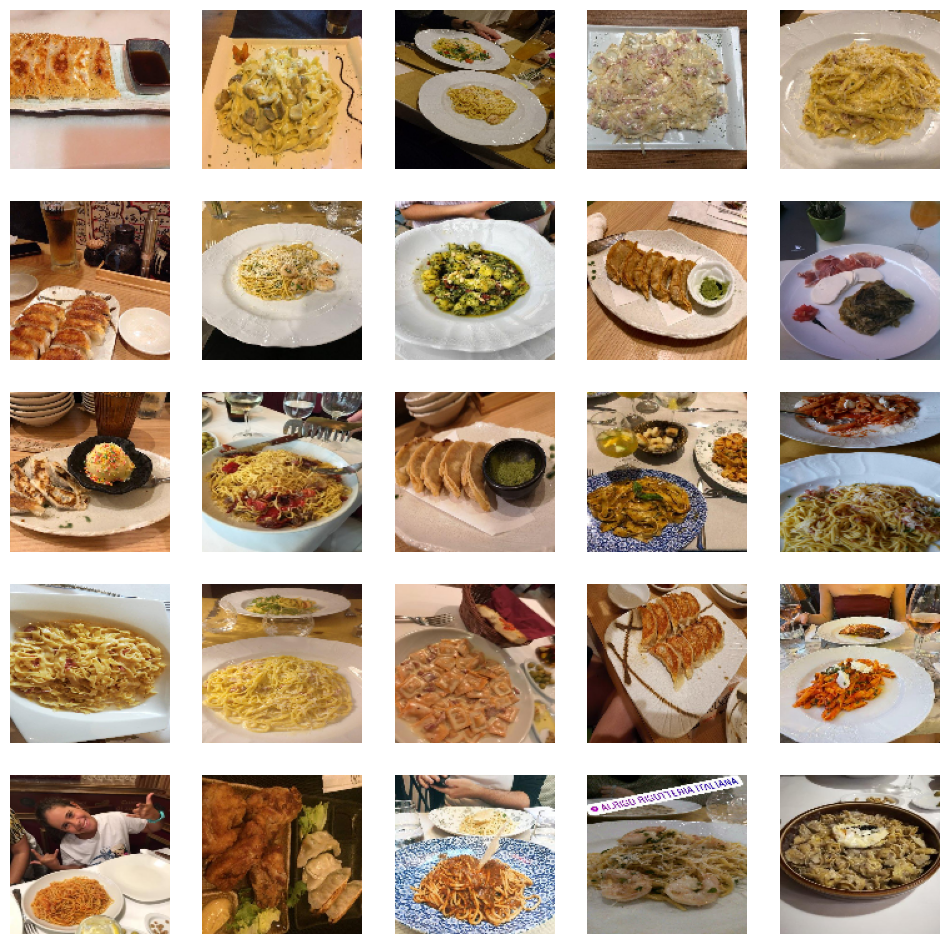

In [168]:

plt.figure(figsize=(12,12))
size = min(int(np.sqrt(len(index_PredRisotto_TruePasta))), 5)
index = np.random.choice(index_PredRisotto_TruePasta, size=size**2, replace=False)

for i in range(len(index)):
        ax = plt.subplot(size,size, i+1)
        plt.imshow(X_test[index[i]])
        plt.axis("off")
plt.savefig("PredictedRisotto_TruePasta.png")


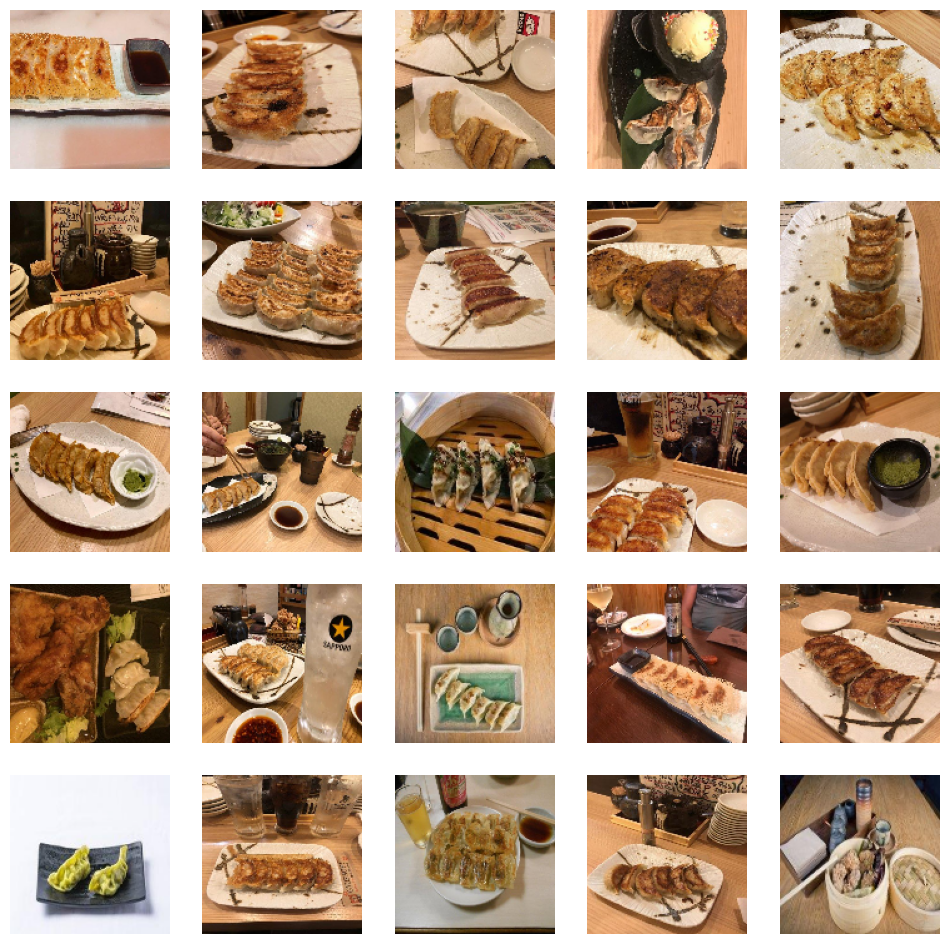

In [167]:
plt.figure(figsize=(12,12))
size = min(int(np.sqrt(len(index_PredRisotto_TrueGyoza))), 5)
index = np.random.choice(index_PredRisotto_TrueGyoza, size=size**2, replace=False)

for i in range(len(index)):
        ax = plt.subplot(size,size, i+1)
        plt.imshow(X_test[index[i]])
        plt.axis("off")
plt.savefig("PredictedRisotto_TrueGyoza.png")

##### **Note**

One thing that we can notice (and it is what I discussed) is that if we look at the wrong predictions on pasta and lasagna and also other classes (like gyozas) we can realize that a lot of the wrongly predicted pictures have white plates (for pasta and lasagna they are also mostly round plates). This might be something that the NN is catching and assigning to "risotto" class. I should further investigate this.

In [160]:
index_PredRisotto_TrueBurrito = [i for i in range(len(preds_test)) if y_test[i]!= preds_test[i] and preds_test[i]==9 and y_test[i]==1]

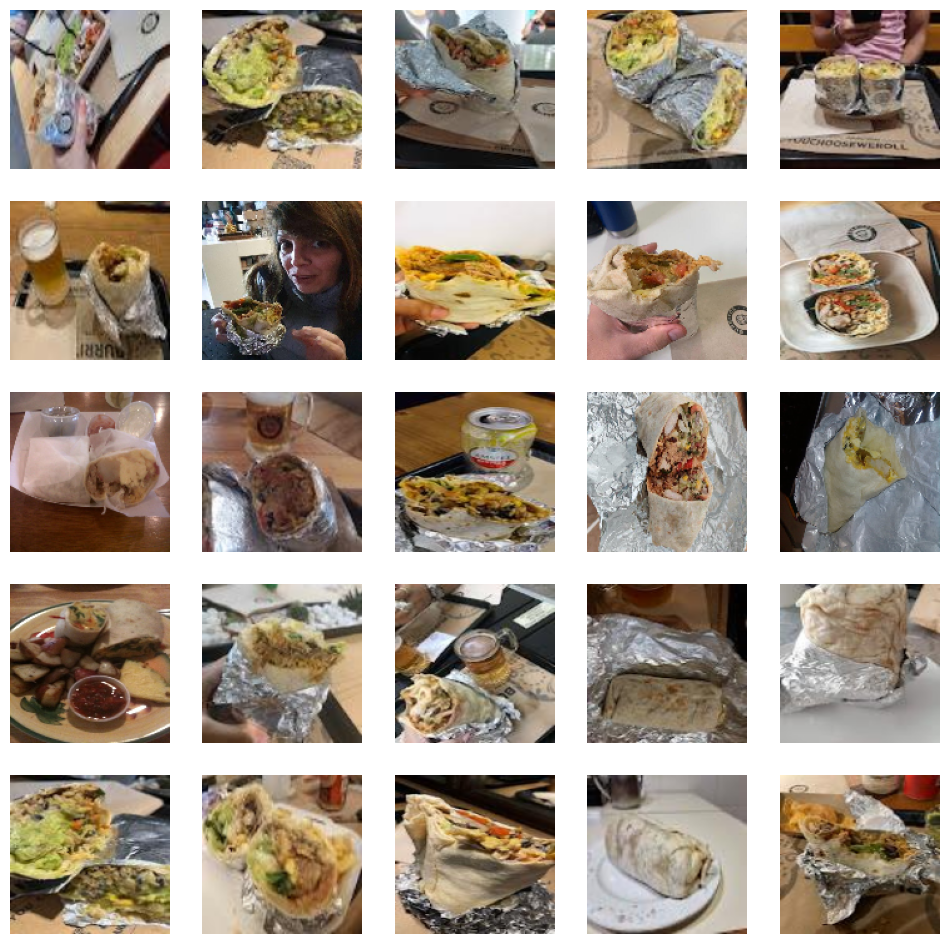

In [166]:
plt.figure(figsize=(12,12))
size = min(int(np.sqrt(len(index_PredRisotto_TrueBurrito))), 5)
index = np.random.choice(index_PredRisotto_TrueBurrito, size=size**2, replace=False)

for i in range(len(index)):
        ax = plt.subplot(size,size, i+1)
        plt.imshow(X_test[index[i]])
        plt.axis("off")
plt.savefig("PredictedRisotto_TrueBurrito.png")

Other classes where the NN predicts "risotto" are burritos and tacos classes. In this case I have no clue of what the NN is doing.

In [163]:
index_PredRisotto_TruePastaGyozaLasagna = [i for i in range(len(preds_test)) if y_test[i]!= preds_test[i] and preds_test[i]==9 and y_test[i] in [8,0,4]]

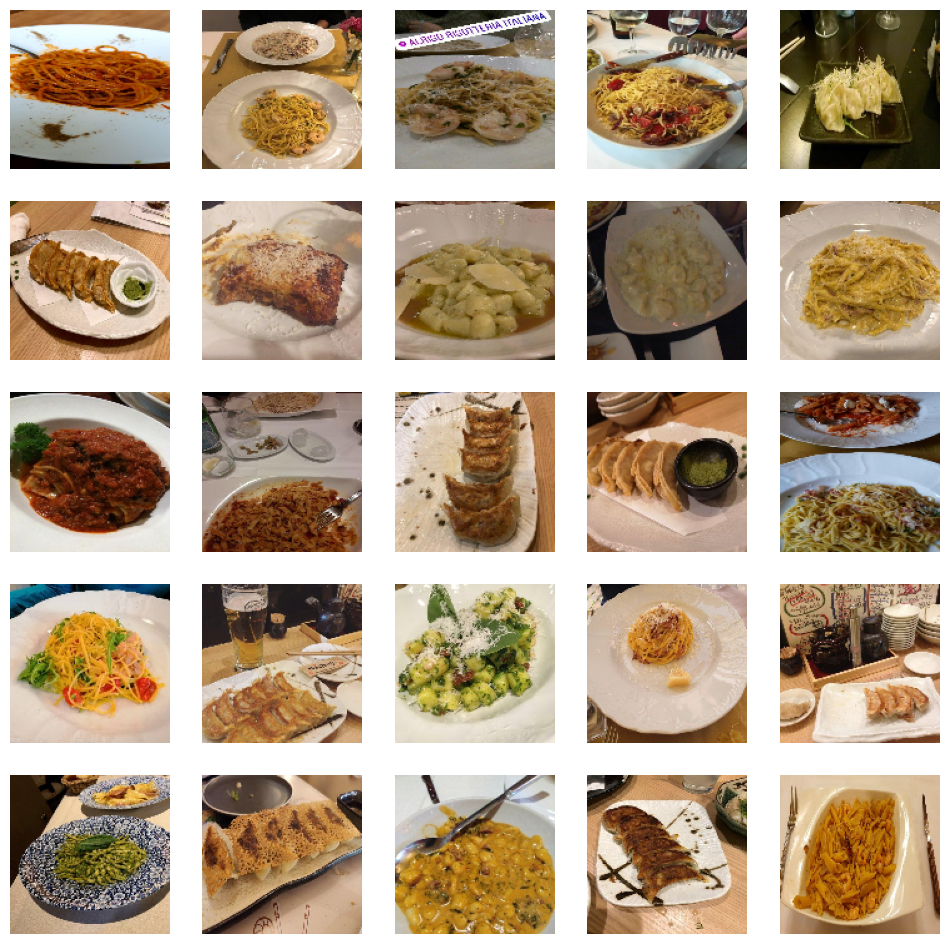

In [165]:
plt.figure(figsize=(12,12))
size = min(int(np.sqrt(len(index_PredRisotto_TruePastaGyozaLasagna))), 5)
index = np.random.choice(index_PredRisotto_TruePastaGyozaLasagna, size=size**2, replace=False)

for i in range(len(index)):
        ax = plt.subplot(size,size, i+1)
        plt.imshow(X_test[index[i]])
        plt.axis("off")
plt.savefig("PredictedRisotto_TrueGyozaLasagnaPasta.png")

## Predictions on type of cuisine

In [23]:
class_label_name = {i:class_name for i ,class_name in enumerate(CLASS_NAMES)}
class_label_name

{0: 'lasagna',
 1: 'burrito',
 2: 'tacos',
 3: 'sushi',
 4: 'gyoza',
 5: 'pizza',
 6: 'sashimi',
 7: 'edamame',
 8: 'pasta',
 9: 'risotto',
 10: 'nachos',
 11: 'ramen'}

In [24]:
true_labels = mapping(y_test, class_label_name)
pred_labels = mapping(preds_test, class_label_name)

In [25]:
confusion_matrix(true_labels, pred_labels, labels = ['italian', 'japanese', "mexican"])

array([[629,  28,  10],
       [122, 175,  25],
       [123,  53, 535]])

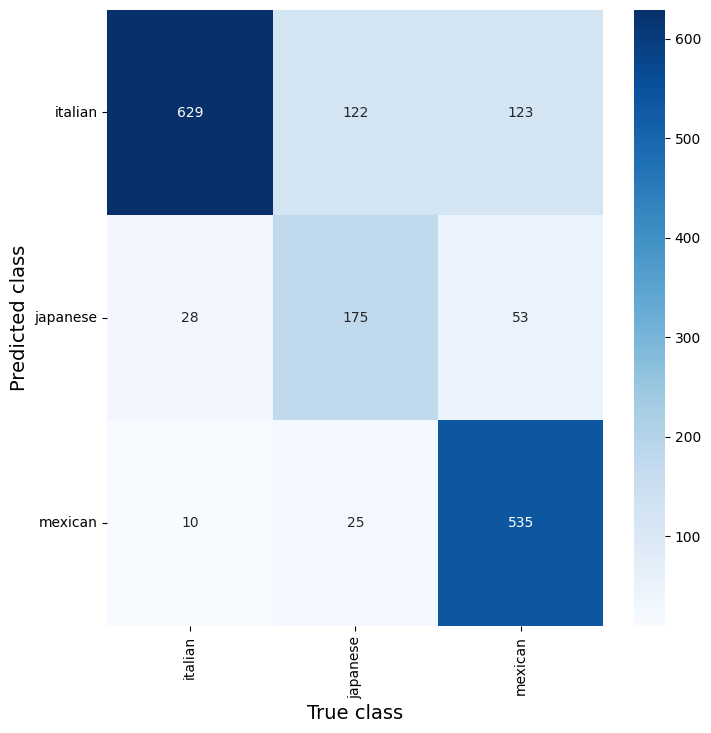

In [26]:
dict_labels = {i : elem for i,elem in enumerate(os.listdir(TEST_PATH))}

xticklabels = ["italian", "japanese", "mexican"]
yticklabels = ["italian", "japanese", "mexican"]
cm = confusion_matrix(true_labels, pred_labels, labels = xticklabels)

plt.figure(figsize=(8,8))
ax = sns.heatmap(cm.T, annot=True, fmt=".0f", cmap='Blues',
             yticklabels=yticklabels, xticklabels=yticklabels)

ax.set_xticklabels(ax.get_xticklabels(), fontsize=10, rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10, rotation=0)

plt.xlabel("True class", fontsize=14)
plt.ylabel("Predicted class", fontsize=14);
plt.savefig("heatmap_finalModel_cuisines.png")

In [27]:
accuracy_score(true_labels, pred_labels)

0.7876470588235294

## Conclusions

- I get an accuracy of 0.66 on validation and 0.62 on test set for the dishes.
- I identify the most problematic classes to be "risotto" and "lasagna". I should further work on this problem.
- I converted the results into classification on different type of cuisines, and I get an accuracy of around 0.79 (with 3 classes of type of cuisines). 
- the most problematic class is "italian" food, due to the problems we have with "risotto" and "lasagna" classes.